MODEL PERFORMANCE & ANALYSIS
- F1 Score by p-thresholds
- Feature Importance

In [457]:
import datetime
import os
import pickle
import pandas as pd
import altair as alt
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from common.paths import Paths
from common.utils.estimations import f1_score_weighted_returns
from sklearn.metrics import f1_score

In [296]:
ex = 'ex2022-03-19_055955-ethusd'

In [297]:
with open(os.path.join(Paths.trade_model, ex, 'boosters.p'), 'rb') as f:
    boosters = pickle.load(f)
with open(os.path.join(Paths.trade_model, ex, 'pred_label_val.p'), 'rb') as f:
    pred_label_val = pickle.load(f)
with open(os.path.join(Paths.trade_model, ex, 'pred_label_ho.p'), 'rb') as f:
    pred_label_ho = pickle.load(f)
# label_val = pred_label_val['label']
# label_ho = pred_label_ho['label']

In [313]:
dct_df2check = pred_label_ho

In [321]:
dfs = []

for quantile, df in dct_df2check.items():
    df = df[[0]].rename(columns={0:"value"}).copy()
    df["cat"] = f'Q-{quantile} HO'
    dfs.append(df)
df = dct_df2check[0.9][["label"]].rename(columns={"label":"value"}).copy()
df['cat'] = 'label HO'
dfs.append(df)

df_long = pd.concat(dfs, axis=0).reset_index()

In [361]:
df_wide=pd.concat([df[[0]] for df in dct_df2check.values()] + [dct_df2check[0.1]["label"]], axis=1)
df_wide.columns=[f'Q-{c}' for c in dct_df2check.keys()] + ['label']
df_wide['confidence_spread'] = df_wide['Q-0.9'] - df_wide['Q-0.1']
label2check = df_wide['label'].copy()
df_wide = df_wide.drop('label', axis=1)

MODEL SCORES

In [418]:
threshold = 1.005
ix_pos_long = np.where(df_wide['Q-0.5'] > threshold)[0]
ix_pos_short = np.where(df_wide['Q-0.5'] < (2-threshold))[0]
ix_pos = ix_pos_long.tolist() + ix_pos_short.tolist()
ix_neg_long = np.array(list(set(np.where(label2check > threshold)[0]).difference(ix_pos)))
ix_neg_short = np.array(list(set(np.where(label2check < (2-threshold))[0]).difference(ix_pos)))
ix_neg = np.array(ix_neg_long.tolist() + ix_neg_short.tolist())

In [458]:
f1_score_weighted_returns(ix_pos_long, ix_pos_short, ix_neg, df_wide['Q-0.5'], label2check)

Weighted F1 Score: 0.10903248609238438


PREDICTION ERRORS

In [300]:
alt.Chart.from_dict({
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "width": 700,
    "data": {
        "values": df_long.sample(1000).to_dict('records')
      },
    "mark": {"type": "line", "tooltip": True},
    "encoding": {
            "x": {"field": "index", "type": "temporal"},
            "y": {"field": "value", "type": "quantitative", "scale": {"domain": [0.985, 1.015]}},
            "color": {"field": "cat"}
  },
})

alt.Chart(...)

In [186]:
for quantile in pred_label_val.keys():
    print(f'QUANTILE: {quantile}')
    print(f"VALIDATION: "
          f"MAE: {mean_absolute_error(pred_label_val[quantile].iloc[:, 0], pred_label_val[quantile]['label'])} "
          f"MSE: {mean_squared_error(pred_label_val[quantile].iloc[:, 0], pred_label_val[quantile]['label'])}")
    print(f"HOLDOUT: "
          f"MAE: {mean_absolute_error(pred_label_ho[quantile].iloc[:, 0], pred_label_ho[quantile]['label'])} "
          f"MSE: {mean_squared_error(pred_label_ho[quantile].iloc[:, 0], pred_label_ho[quantile]['label'])}")
    print(f"RETURN == 1: "
          f"MAE: {mean_absolute_error(np.ones(len(pred_label_ho[quantile])), pred_label_ho[quantile]['label'])} "
          f"MSE: {mean_squared_error(np.ones(len(pred_label_ho[quantile])), pred_label_ho[quantile]['label'])}")

QUANTILE: 0.1
VALIDATION: MAE: 0.009731231291461825 MSE: 0.00013420873181948828
HOLDOUT: MAE: 0.013125575221637579 MSE: 0.00022320699674800194
RETURN == 1: MAE: 0.005701243744073382 MSE: 7.202781170024736e-05
QUANTILE: 0.5
VALIDATION: MAE: 0.0065367191767678684 MSE: 6.688001684383511e-05
HOLDOUT: MAE: 0.0065427650752758835 MSE: 8.68992002673856e-05
RETURN == 1: MAE: 0.005701243744073382 MSE: 7.202781170024736e-05
QUANTILE: 0.9
VALIDATION: MAE: 0.007573369606306947 MSE: 8.377127783130546e-05
HOLDOUT: MAE: 0.006664719722744587 MSE: 8.035628634893426e-05
RETURN == 1: MAE: 0.005701243744073382 MSE: 7.202781170024736e-05


In [187]:
lst = []
for quantile in pred_label_val.keys():
    lst.append({'stage': 'VAL',
                'quantile': quantile,
                'MAE': mean_absolute_error(pred_label_val[quantile].iloc[:, 0], pred_label_val[quantile]['label']),
                'MSE': mean_squared_error(pred_label_val[quantile].iloc[:, 0], pred_label_val[quantile]['label'])
                })
    lst.append({'stage': 'HO',
                'quantile': quantile,
                'MAE': mean_absolute_error(pred_label_ho[quantile].iloc[:, 0], pred_label_ho[quantile]['label']),
                'MSE': mean_squared_error(pred_label_ho[quantile].iloc[:, 0], pred_label_ho[quantile]['label'])
                })
    lst.append({'stage': 'HO - BASELINE PRED=1',
                'quantile': quantile,
                'MAE': mean_absolute_error(np.ones(len(pred_label_ho[quantile])), pred_label_ho[quantile]['label']),
                'MSE': mean_squared_error(np.ones(len(pred_label_ho[quantile])), pred_label_ho[quantile]['label'])
                })

In [188]:
alt.Chart.from_dict({
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "width": 600,
  "data": {
    "values": lst
  },
  "mark": "line",
  "encoding": {
    "x": {"field": "quantile", "type": "ordinal"},
    "y": {"field": "MAE", "type": "quantitative"},
      "color": {"field": "stage"},
  },
})

alt.Chart(...)

PREDICTION ERRORS by confidence. Smaller confidence, lower error ?

In [196]:
df=pd.concat([df[[0]] for df in pred_label_ho.values()] + [pred_label_ho[0.1]["label"]], axis=1)
df.columns=list(pred_label_ho.keys()) + ['label']
df['confidence_spread'] = df[0.9] - df[0.1]

,0.1,0.5,0.9,label,confidence_spread
2022-02-24 05:41:42.168000+00:00,0.987418,0.998540,1.004253,1.006584,0.016836
2022-02-24 05:41:45+00:00,0.987437,0.998832,1.004059,1.006584,0.016622
2022-02-24 05:41:56.996000+00:00,0.987437,0.998832,1.004059,1.006584,0.016622
2022-02-24 05:42:00+00:00,0.987214,0.998925,1.004049,1.004365,0.016835
2022-02-24 05:42:15+00:00,0.987541,0.998720,1.003787,1.004365,0.016246
...,...,...,...,...,...
2022-03-01 23:13:00+00:00,0.989055,0.997060,1.001306,1.000895,0.012252
2022-03-01 23:13:15+00:00,0.988996,0.996893,1.001339,1.000895,0.012343
2022-03-01 23:13:30+00:00,0.988987,0.996904,1.001307,1.000895,0.012320
2022-03-01 23:13:45+00:00,0.988992,0.996909,1.001323,1.000895,0.012331


In [203]:
alt.Chart.from_dict({
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "title": "Confidence Spread over time",
  "width": 600,
  "data": {
    "values": df.reset_index()[['index', 'confidence_spread']].sample(1000).to_dict('records')
  },
  "mark": "line",
  "encoding": {
    "x": {"field": "index", "type": "temporal"},
    "y": {"field": "confidence_spread", "type": "quantitative"},
  },
})

alt.Chart(...)

In [266]:
df

,0.1,0.5,0.9,label,confidence_spread,0.5 - Label,A0.5 - Label,A,B,Loss,mid
2022-02-24 05:41:42.168000+00:00,0.987418,0.998540,1.004253,1.006584,0.016836,-0.008043,-0.008043,-0.008043,0.016836,-0.008043,0.998540
2022-02-24 05:41:45+00:00,0.987437,0.998832,1.004059,1.006584,0.016622,-0.007752,-0.007752,-0.007752,0.016622,-0.007752,0.998832
2022-02-24 05:41:56.996000+00:00,0.987437,0.998832,1.004059,1.006584,0.016622,-0.007752,-0.007752,-0.007752,0.016622,-0.007752,0.998832
2022-02-24 05:42:00+00:00,0.987214,0.998925,1.004049,1.004365,0.016835,-0.005440,-0.005440,-0.005440,0.016835,-0.005440,0.998925
2022-02-24 05:42:15+00:00,0.987541,0.998720,1.003787,1.004365,0.016246,-0.005646,-0.005646,-0.005646,0.016246,-0.005646,0.998720
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01 23:13:00+00:00,0.989055,0.997060,1.001306,1.000895,0.012252,-0.003835,-0.003835,-0.003835,0.012252,-0.003835,0.997060
2022-03-01 23:13:15+00:00,0.988996,0.996893,1.001339,1.000895,0.012343,-0.004003,-0.004003,-0.004003,0.012343,-0.004003,0.996893
2022-03-01 23:13:30+00:00,0.988987,0.996904,1.001307,1.000895,0.012320,-0.003991,-0.003991,-0.003991,0.012320,-0.003991,0.996904
2022-03-01 23:13:45+00:00,0.988992,0.996909,1.001323,1.000895,0.012331,-0.003986,-0.003986,-0.003986,0.012331,-0.003986,0.996909


In [ ]:
df['mid'] = df['0.5']
df['low'] = df['0.1']
df['up'] = df['0.9']

In [293]:
quantile_mae = {}
quantiles = list(range(1, 10))
for quantile in quantiles:
    threshold_high = df['0.5'].quantile(quantile/10)
    threshold_low = df['0.5'].quantile((quantile-1)/10)
    ix = np.where((df['0.5'] > threshold_low) & (df['0.5'] < threshold_high))[0]
    quantile_mae[round(threshold_high - (threshold_high - threshold_low)/2, 3)] = mean_absolute_error(df.iloc[ix]['0.5'], df.iloc[ix]['label'])

In [294]:
# For this one want to have count sample as well
# instead 
alt.Chart.from_dict({
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "width": 600,
    "title": "Quantile of Predicted return",
    "description": "Ideally error towards zero with lower spread",
  "data": {
    "values": [{'quantile': k, 'Loss': v} for k, v in quantile_mae.items()]
  },
  "mark": "line",
  "encoding": {
    "x": {"field": "quantile", "type": "ordinal", "title": "Quantile of Predicted return"},
    "y": {"field": "Loss", "type": "quantitative", "title": "MAE"},
  },
})

alt.Chart(...)

In [270]:
quantile_mae = {}
quantiles = list(range(1, 10))
for quantile in quantiles:
    threshold_high = df['confidence_spread'].quantile(quantile/10)
    threshold_low = df['confidence_spread'].quantile((quantile-1)/10)
    ix = np.where((df['confidence_spread'] > threshold_low) & (df['confidence_spread'] < threshold_high))[0]
    quantile_mae[quantile] = mean_absolute_error(df.iloc[ix]['0.5'], df.iloc[ix]['label'])

In [244]:
df.columns = [str(c) for c in df.columns]
df["Loss"] = df["0.5"] - df['label']

In [245]:
alt.Chart.from_dict({
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "width": 600,
    "title": "Regression error against confidence spread of 0.1 and 0.9 line",
    "description": "Ideally error towards zero with lower spread",
  "data": {
    "values": df[["Loss", "confidence_spread"]].sample(1000).to_dict('records')
  },
  "mark": {
      "type": "point",
    "size": 1,  
  },
  "encoding": {
    "x": {"field": "confidence_spread", "type": "quantitative", "title": "Confidence spread"},
    "y": {"field": "Loss", "type": "quantitative", "title": "0.5 Regression Error"
#           "scale": {"domain": [0.95, 1]}
         },
#       "color": {"field": "B"},
  },
})

alt.Chart(...)

In [272]:
alt.Chart.from_dict({
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "width": 600,
   "title": "Tranches of Confidence Spread against 0.5 MAE Loss.",
    "description": "Ideally -x**2 mirror parabolic",
  "data": {
    "values": [{'quantile': k, 'Loss': v} for k, v in quantile_mae.items()]
  },
  "mark": "line",
  "encoding": {
    "x": {"field": "quantile", "type": "ordinal", "title": "Quantile of regression confidence spread"},
    "y": {"field": "Loss", "type": "quantitative", "title": "Loss of 0.5 qt regression model"
#           "scale": {"domain": [0.95, 1]}
         },
#       "color": {"field": "stage"},
  },
})

alt.Chart(...)

How does the error correlate significant high return events?

In [256]:
alt.Chart.from_dict({
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "width": 600,
    "title": "Future Return against Regression Error. Ideally a horizontal line thinning out on ends.",
  "data": {
    "values": df[["Loss", "label"]].sample(1000).to_dict('records')
  },
  "mark": {
      "type": "point", 
      "size": 1,  
  },
  "encoding": {
    "x": {"field": "label", "type": "quantitative", "title": "Future Return", "scale": {"domain": [0.95, 1.05]}},
    "y": {"field": "Loss", "type": "quantitative", "title": "0.5 Regression Error"},
  },
})

alt.Chart(...)

In [281]:
alt.Chart.from_dict({
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "width": 600,
    "title": "Future Return against Predicted. Should ideally be a circle...",
  "data": {
    "values": df[["mid", "label"]].sample(1000).to_dict('records')
  },
  "mark": {
      "type": "point", 
      "size": 1,  
  },
  "encoding": {
    "x": {"field": "label", "type": "quantitative", "title": "Future Return", "scale": {"domain": [0.95, 1.05]}},
    "y": {"field": "mid", "type": "quantitative", "title": "Predicted", "scale": {"domain": [0.95, 1.05]}},
  },
})

alt.Chart(...)

In [280]:
alt.Chart.from_dict({
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "width": 600,
    "title": "Future Return against Confidence Range. Best if a reverse parabola",
  "data": {
    "values": df[["confidence_spread", "label"]].sample(1000).to_dict('records')
  },
  "mark": {
      "type": "point", 
      "size": 1,  
  },
  "encoding": {
    "x": {"field": "label", "type": "quantitative", "title": "Future Return", "scale": {"domain": [0.95, 1.05]}},
    "y": {"field": "confidence_spread", "type": "quantitative", "title": "confidence_spread"},
  },
})

alt.Chart(...)

More questions. Hypothesis. P values. confidence intervals such as:
Given a predicted return increase of [x1,.. xn], how likely is that the return goes over [y1, .. yn]
Basically, is anything better than guess, at least marginally?

**Mini Backtest**
- Entry:
    - Predicted return </> thresholds
    - Confidence spread < its mean
- Exit conditions:
    - Trailing Stop Loss
    - Timeout
    - Predictions suggest reversal
    - Maybe profit taking ...
Plot Graph 2 images. Prices and PnL Series. Each couple layers (buy sell points)

Feature Importance

In [ ]:
# from common.utils.util_func import get_model_fscore
# importances = [get_model_fscore(booster) for booster in self.boosters]
# res = pd.DataFrame(importances).mean(axis=0).sort_values(ascending=False)
# logger.info(res)

In [25]:
from common.utils.util_func import get_model_fscore

importances = [get_model_fscore(booster) for booster in boosters]
res = pd.DataFrame(importances).mean(axis=0).sort_values(ascending=False)

C:\Users\seb\Anaconda37\envs\py38\lib\site-packages\pandas\plotting\_matplotlib\core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

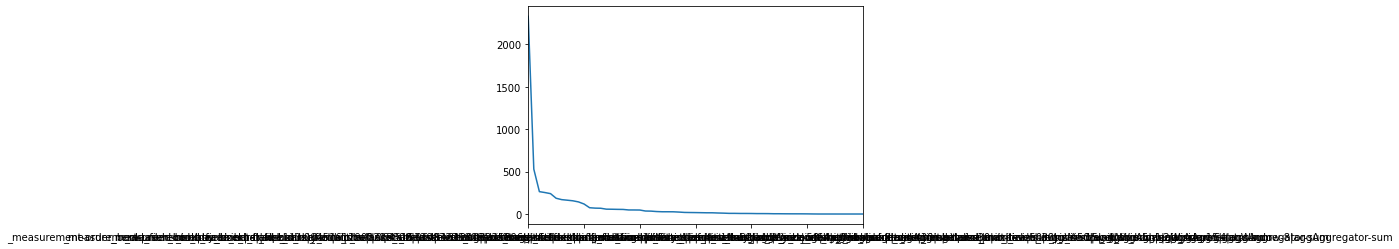

In [27]:
res.plot()

F1 Scores

In [28]:
print(res.iloc[:10])

_measurement-trade_bars|_field-imbalance_size|asset-ethusd|exchange-bitfinex|information-imbalance|unit-tick|unit_size-50|aggWindow-64|aggAggregator-sum                                                                                             2332.182485
_measurement-trade_bars|_field-imbalance_size|asset-ethusd|exchange-bitfinex|information-imbalance|unit-ethusd|unit_size-50|aggWindow-128|aggAggregator-sum                                                                                           529.424458
_measurement-order_book|_field-bid_buy_size_ratio|alpha-0.06451612903225806|asset-ethusd|exchange-bitfinex|information-bid_buy_size_ratio_imbalance_ratio_resampled_max|levels-30|unit-size_ewm_sum|unit_size-15|aggWindow-128|aggAggregator-sum      263.948117
_measurement-trade_bars|_field-imbalance_size|asset-ethusd|exchange-bitfinex|information-imbalance|unit-tick|unit_size-50|aggWindow-128|aggAggregator-sum                                                                            

VALIDATION F1

In [31]:
with open(os.path.join(Paths.trade_model, ex, 'preds.p'), 'rb') as f:
    preds = pickle.load(f)
with open(os.path.join(Paths.trade_model, ex, 'label.p'), 'rb') as f:
    label = pickle.load(f)

In [40]:
f1 = preds.merge(label, how='inner', right_index=True, left_index=True)

HOLDOUT SET VALIDATION

In [64]:
from layers.predictions.predict import Predict

In [65]:
start = datetime.datetime(2022, 2, 17)
end = datetime.datetime(2022, 3, 1)
f1_ho = Predict(boosters, start, end)

In [ ]:
# with open(os.path.join(Paths.trade_model, ex, 'f1_ho.p'), 'rb') as f:
#     f1_ho = pickle.load(f)
for i, side in enumerate(['short', 'flat', 'long']):
    print(f"{side}: {f1_score(np.where(f1_ho['label'] == i, 1, 0), f1_ho[side].round().values)}")